In [1]:
import numpy as np
import pandas as pd

input_file = "../data/network_backup_dataset.csv"
df = pd.read_csv(input_file, header = 0)
labels = df.columns
for i, v in enumerate(labels):
    print "labels[" + str(i) + "] => " + v

labels[0] => Week #
labels[1] => Day of Week
labels[2] => Backup Start Time - Hour of Day
labels[3] => Work-Flow-ID
labels[4] => File Name
labels[5] => Size of Backup (GB)
labels[6] => Backup Time (hour)


In [2]:
week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

def convert_to_scalar(typeId, content):
    '''
    return the scalar encoding of the feature
    typeId 1 => Day of the week
    typeId 2 => Hour of the day
    typeId 3 => Work-flow number
    typeId 4 => File-type
    typeId 0 => Week number
    typeId 5 => Size of backup (GB)
    '''
    if typeId == 1:
        return week.index(content) + 1
    elif typeId == 2:
        return int(content)
    elif typeId == 3:
        return int(content.split('_')[2])
    elif typeId == 4:
        return int(content.split('_')[1])
    elif typeId == 0:
        return int(content)
    elif typeId == 5:
        return float(content)
    else:
        raise Exception('invalid typeId')
        
def transform_to_scalar(row):
    '''
    return a transformed scalar row
    parameter row is row in dataset
    '''
    a = []
    for i, v in enumerate(row[:6]):
        a.append(convert_to_scalar(i, v))

    return a

In [6]:
from sklearn.cross_validation import cross_val_predict
from sklearn.model_selection import KFold

dataset_scalar = map(transform_to_scalar, df.as_matrix())

In [7]:
# get the rmse
def get_rmse(target, predict):
    n = len(predict)
    total = sum([(target[i] - predict[i])**2 for i in range(n)])
    return (total / n) ** 0.5

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt 

# plot the rmse 
def plot_rmse(degree, train_rmse, test_rmse, title):
    plt.plot(degree, train_rmse, label = "train_rmse")
    plt.plot(degree, test_rmse, label = "test_rmse")
    plt.title(title)
    plt.xlabel('number of neighbors')
    plt.ylabel('RMSE')
    plt.legend(loc = 1, fancybox = True, framealpha = 0.5, prop = {'size': 8})
    plt.show()

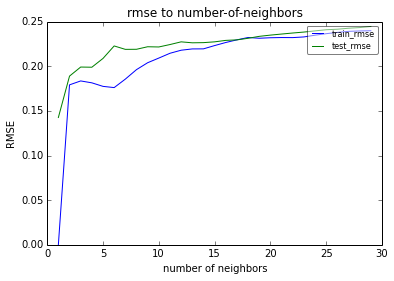

In [14]:
from sklearn.neighbors import KNeighborsRegressor

number_of_neighbors = range(1, 30)
n_splits = 10
kf = KFold(n_splits = n_splits)

train_rmse = [0] * len(number_of_neighbors)
test_rmse = [0] * len(number_of_neighbors)

for train_index, test_index in kf.split(dataset_scalar):
    train_set = [dataset_scalar[i] for i in train_index]
    test_set = [dataset_scalar[i] for i in test_index]
    train = map(lambda x: x[:3] + x[4:5], train_set)
    train_target = map(lambda x: x[5], train_set)
    test = map(lambda x: x[:3] + x[4:5], test_set)
    test_target = map(lambda x: x[5], test_set)
        
    for i, k in enumerate(number_of_neighbors):
        neigh = KNeighborsRegressor(n_neighbors = k)
        neigh.fit(train, train_target)

        train_predict = neigh.predict(train)
        test_predict = neigh.predict(test)

        train_rmse[i] += get_rmse(train_target, train_predict)
        test_rmse[i] += get_rmse(test_target, test_predict)
        
train_rmse = map(lambda x: (x / 10) ** 0.5, train_rmse)
test_rmse = map(lambda x: (x / 10) ** 0.5, test_rmse)
plot_rmse(number_of_neighbors, train_rmse, test_rmse, "rmse to number-of-neighbors")